<center><h1> Notebook Finding a Better Place Restourant at Scarborough</h1></center>

<h2> 1. Importing Library </h2>

In [33]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import geocoder

import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

import json
import xml
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

<h2> 2. Data Collection and Cleansing</h2>

In [9]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
get_data = requests.get(url).text
data_html = BeautifulSoup(get_data, 'lxml')

<h3> 2.1. Converting html to dataframe</h3>

In [12]:
col_name = ['Postalcode','Borough','Neighborhood']
df_toronto = pd.DataFrame(columns = col_name)
postalcode= []
borough = []
neighborhood = []
for value in data_html.find('table').find_all('tr'):
    values = value.find_all('td')
    if(len(values) > 0):
        postalcode.append(values[0].text.rstrip('\n'))
        borough.append(values[1].text.rstrip('\n'))
        neighborhood.append(values[2].text.rstrip('\n'))

In [14]:
df_toronto['Postalcode'] = postalcode
df_toronto['Borough'] = borough
df_toronto['Neighborhood'] = neighborhood
df_toronto.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


<h3> 2.2. Data Cleansing</h3>

In [23]:
tor = df_toronto[df_toronto['Borough'] != 'Not assigned'].reset_index(drop = True)
group_tor = tor.groupby(['Postalcode','Borough'], as_index=False)
group_tor = group_tor.agg(lambda x: ",".join(x))
group_tor

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [25]:
group_tor.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M5A,North York,Downsview
freq,1,24,4


In [27]:
group_tor = group_tor.dropna()
empty = 'Not assigned'
group_tor = group_tor[(group_tor.Postalcode != empty ) & (group_tor.Borough != empty) & (group_tor.Neighborhood != empty)]
group_tor

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [28]:
group_tor.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M5A,North York,Downsview
freq,1,24,4


In [31]:
print(group_tor.shape)
group_tor.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h3>2.3. Getting Latitude Longitude</h3>

In [34]:
def latlong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
latlong('M1B')[0]

43.811390000000074

In [35]:
lat= []
long = []
for i in group_tor['Postalcode'].values:
    lat.append(latlong(i)[0])
    long.append(latlong(i)[1])
group_tor['Latitude'] = lat
group_tor['Longitude'] = long
group_tor

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892
...,...,...,...,...,...
98,M9N,York,Weston,43.70507,-79.51804
99,M9P,Etobicoke,Westmount,43.69630,-79.52926
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.68681,-79.55728
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.74453,-79.58624


In [37]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="user_agent")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.7729744, -79.2576479.


<h2> 3. Mapping of Scarborough</h2>

In [39]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y],
                             zoom_start=10)

for lat, lng, nei in zip(group_tor['Latitude'], group_tor['Longitude'],
                         group_tor['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [41]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent = 'user_agent')
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [43]:
# @hiddel_cell
CLIENT_ID = 'U3UNULX5P0AHIYGYL1QSKLPDNQS4RJ0INV5LK12GBSBEHZZV' # my Foursquare ID
CLIENT_SECRET = 'ZHFR5O3ZO5WU3PHVLR3F0L4E5TZAHAAOXFEZDXYRYPEH4RAJ' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: U3UNULX5P0AHIYGYL1QSKLPDNQS4RJ0INV5LK12GBSBEHZZV
CLIENT_SECRET: ZHFR5O3ZO5WU3PHVLR3F0L4E5TZAHAAOXFEZDXYRYPEH4RAJ


In [45]:
r = 700
limit = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
    longitude_n1, 
    r, 
    limit)
result = requests.get(url).json()

In [46]:
result

{'meta': {'code': 200, 'requestId': '5fed293d67c4b00207618d49'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Scarborough City Centre',
  'headerFullLocation': 'Scarborough City Centre, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 51,
  'suggestedBounds': {'ne': {'lat': 43.77927440630001,
    'lng': -79.24893946630628},
   'sw': {'lat': 43.766674393699994, 'lng': -79.26635633369371}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5085ec39e4b0b1ead2eb0818',
       'name': 'Disney Store',
       'location': {'address': '300 Borough Drive',
        'crossStreet': 'in Scarborough Town Centre',
        'lat': 43.775537,
        'lng': -79.256833,
     

In [48]:
venues=result['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [49]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h3>4. Nearby Venues/Location</h3>

In [50]:

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
3,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
4,Shoppers Drug Mart,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",43.773305,-79.251662


<h3>5. Categories of Nearby Venues/Location</h3>

In [52]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
3,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
4,Shoppers Drug Mart,Pharmacy,43.773305,-79.251662


<h4>5.1. Top 10 categories</h4>

In [59]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store      7
Restaurant          4
Coffee Shop         4
Pharmacy            2
Gas Station         2
Intersection        2
Sandwich Place      2
Department Store    2
Gym                 1
Bakery              1
Name: categories, dtype: int64

<h4>5.2. Geatting Nearby</h4>

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
Scarborough_venues = getNearbyVenues(names=group_tor['Neighborhood'],
                                   latitudes=group_tor['Latitude'],
                                   longitudes=group_tor['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [64]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 252 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,23,23,23,23,23,23
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",14,14,14,14,14,14
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


<h4>5.3. One Hot Encoding of feature</h4>

In [66]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,College Theater,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [67]:

num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                       venue  freq
0         Chinese Restaurant  0.09
1              Shopping Mall  0.09
2  Latin American Restaurant  0.04
3           Sushi Restaurant  0.04
4                Supermarket  0.04


---- Alderwood, Long Branch ----
            venue  freq
0  Sandwich Place  0.12
1             Pub  0.12
2     Gas Station  0.12
3             Gym  0.12
4     Coffee Shop  0.12


---- Bathurst Manor, Wilson Heights, Downsview North ----
           venue  freq
0    Pizza Place  0.14
1    Coffee Shop  0.14
2           Park  0.14
3  Grocery Store  0.07
4  Deli / Bodega  0.07


---- Bayview Village ----
                venue  freq
0  Golf Driving Range   0.2
1                Park   0.2
2         Gas Station   0.2
3               Trail   0.2
4    Asian Restaurant   0.2


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2  Italian Restaurant  0.08
3         Pizza Place  0.04
4       Gro

4   Tennis Court  0.12


---- North Park, Maple Leaf Park, Upwood Park ----
                    venue  freq
0            Home Service  0.17
1                  Bakery  0.17
2                    Park  0.17
3        Business Service  0.17
4  Furniture / Home Store  0.17


---- North Toronto West,  Lawrence Park ----
                 venue  freq
0  Sporting Goods Shop  0.10
1                 Café  0.10
2          Coffee Shop  0.10
3                Diner  0.07
4   Italian Restaurant  0.07


---- Northwest, West Humber - Clairville ----
                       venue  freq
0  Middle Eastern Restaurant   0.1
1              Auto Workshop   0.1
2             Sandwich Place   0.1
3                Gas Station   0.1
4           Storage Facility   0.1


---- Northwood Park, York University ----
                 venue  freq
0          Coffee Shop   0.1
1  Japanese Restaurant   0.1
2                  Bar   0.1
3                 Bank   0.1
4          Pizza Place   0.1


---- Old Mill South, King's Mill 

                venue  freq
0                Park   1.0
1         Zoo Exhibit   0.0
2        Noodle House   0.0
3       Metro Station   0.0
4  Mexican Restaurant   0.0




<h4> 5.4. Most Common Venues</h4>

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Supermarket,Japanese Restaurant,Breakfast Spot,Latin American Restaurant,Skating Rink,Sandwich Place
1,"Alderwood, Long Branch",Pizza Place,Gym,Sandwich Place,Athletics & Sports,Pub,Coffee Shop,Gas Station,Pharmacy,Cosmetics Shop,Falafel Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Park,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Deli / Bodega,Sandwich Place,Fried Chicken Joint,Grocery Store
3,Bayview Village,Asian Restaurant,Golf Driving Range,Park,Gas Station,Trail,Yoga Studio,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Pub,Cupcake Shop,Sushi Restaurant,Intersection,Juice Bar,Indian Restaurant,Thai Restaurant


<h4>5.5. K-Means Cluestering Approach</h4>

In [80]:
from sklearn.cluster import KMeans
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [81]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =group_tor.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,0,Zoo Exhibit,Construction & Landscaping,Fast Food Restaurant,Distribution Center,Fish & Chips Shop,Field,Farmers Market,Farm,Falafel Restaurant,Event Space
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,0,Construction & Landscaping,Fish & Chips Shop,Home Service,Bar,Dog Run,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,1,Park,Gymnastics Gym,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
3,M1G,Scarborough,Woburn,43.76812,-79.21761,0,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Park,Yoga Studio,Ethiopian Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,0,Bakery,Gas Station,Hakka Restaurant,Lounge,Thai Restaurant,Caribbean Restaurant,Bank,Athletics & Sports,Escape Room,Donut Shop


In [82]:

kclusters = 10
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [124]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [125]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":group_tor["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [126]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

In [127]:
Scarborough_Avg_HousingPrice = Scarborough_Avg_HousingPrice.sort_values('Average_Housing_Price', ascending = False)

Text(0.5, 1.0, 'TOP 10 AVERAGE HOUSING PRICE')

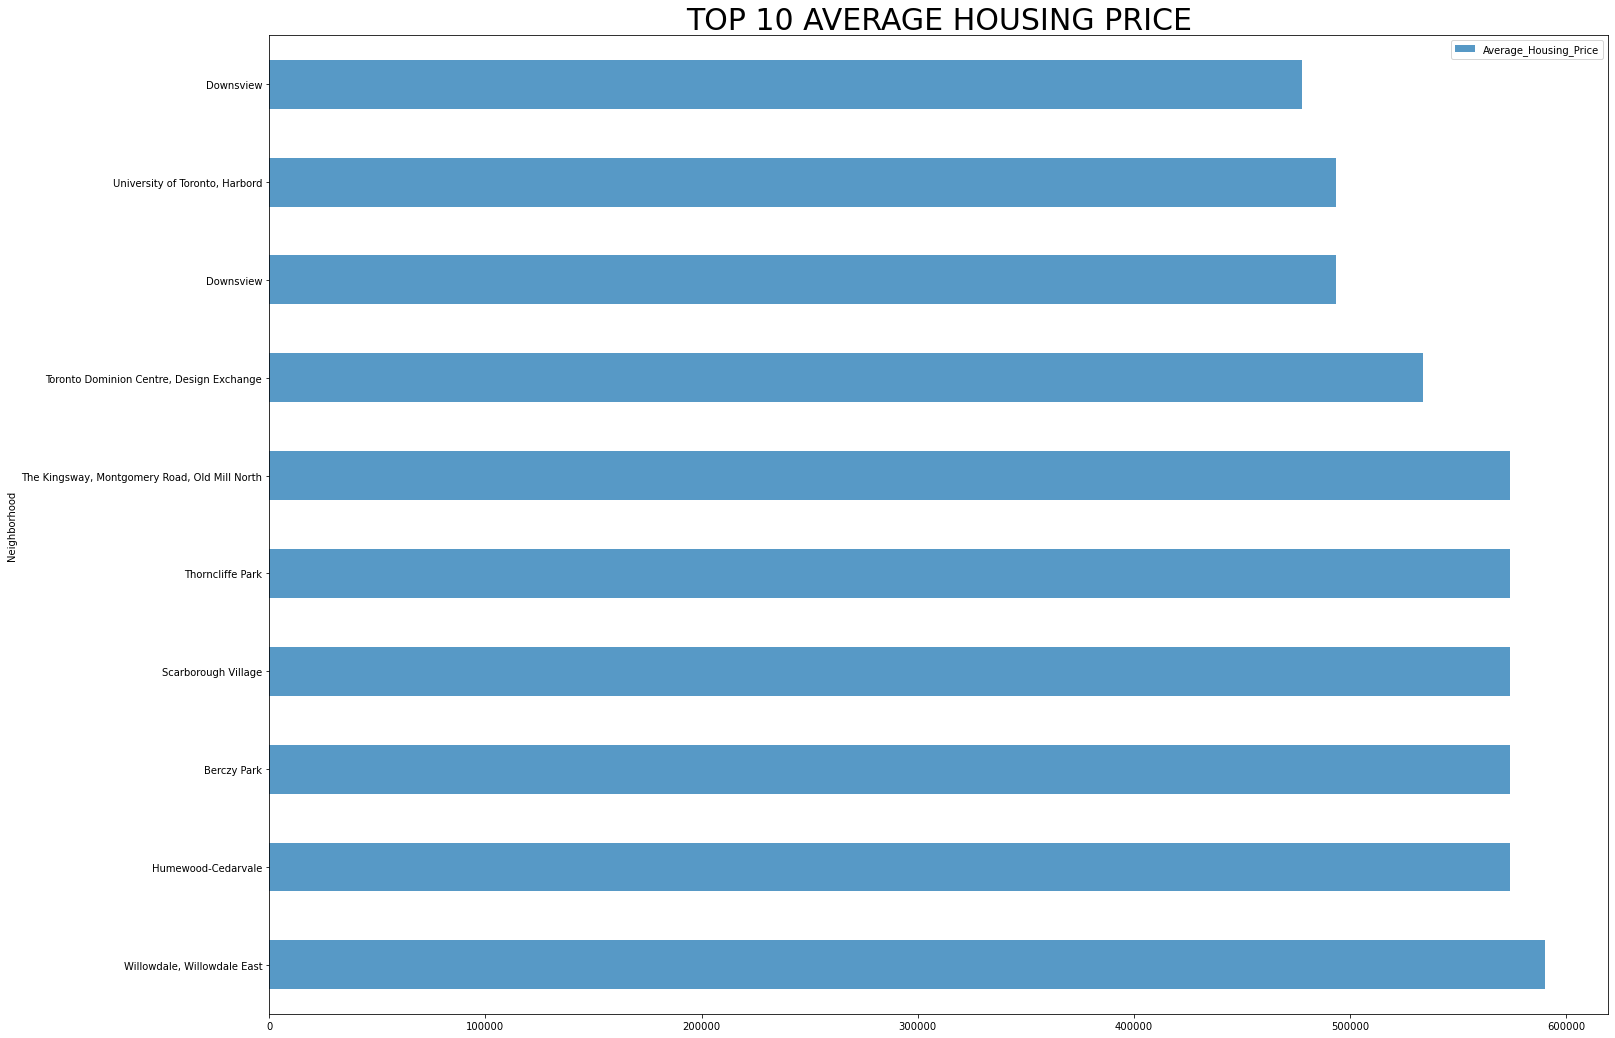

In [156]:
Scarborough_Avg_HousingPrice.head(10).plot(kind='barh',figsize=(24,18),alpha=0.75)
plt.title('TOP 10 AVERAGE HOUSING PRICE', size = 30)

In [138]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [139]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":group_tor["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [140]:

Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

In [141]:
Scarborough_school_ratings

,Top School Rating
Neighborhood,
"Malvern, Rouge",7
"Rouge Hill, Port Union, Highland Creek",9
"Guildwood, Morningside, West Hill",5
Woburn,8
Cedarbrae,10
...,...
Weston,5
Westmount,6
"Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens",5


In [144]:
Scarborough_school_ratings = Scarborough_school_ratings.sort_values('Top School Rating', ascending = False)

Text(0.5, 1.0, 'TOP 10 School Rating')

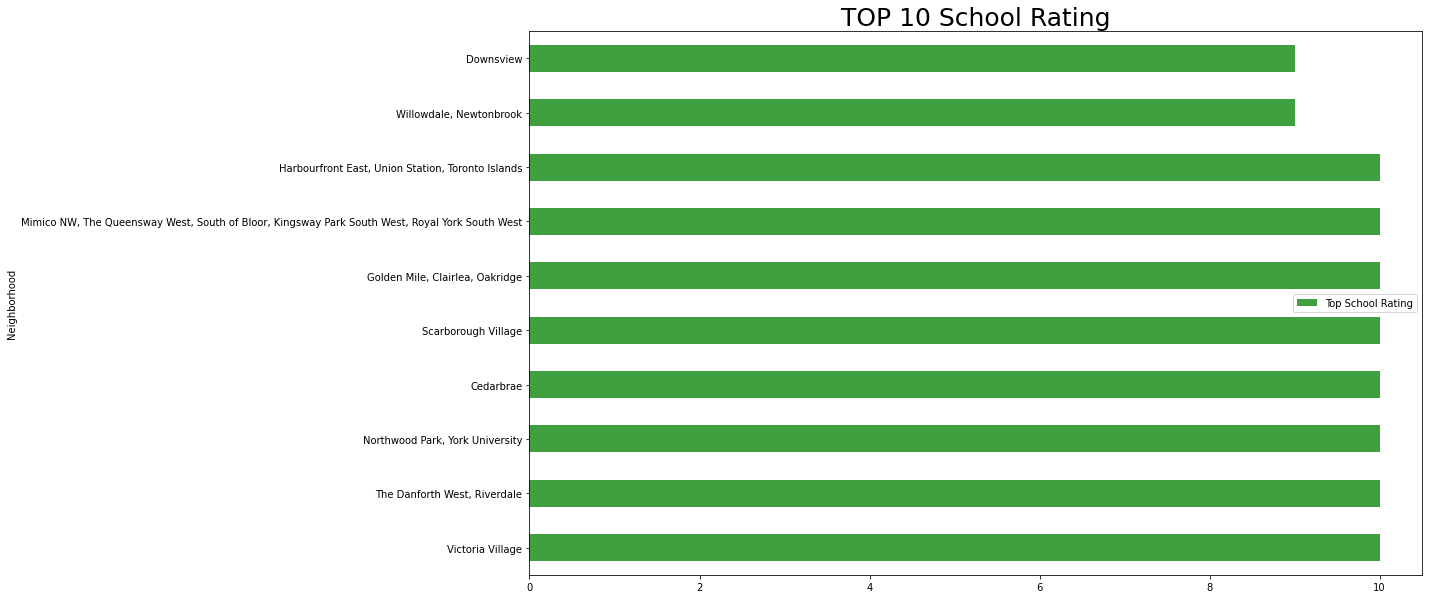

In [159]:

Scarborough_school_ratings.head(10).plot(kind='barh',figsize=(16,10),color='green',alpha=0.75);
plt.title('TOP 10 School Rating', size = 25)

<h2>Conclusion:</h2> 

In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.